In [262]:
import numpy
from scipy import signal
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.df import streamgapdf, impulse_deltav_plummer_curvedstream
from galpy.util import bovy_conversion, bovy_coords
%pylab inline
R0, V0= 8., 220.
import seaborn as sns
#a = sns.plotting_context('ipython')
sns.set_style('ticks',
              {'xtick.direction': u'in',
               'ytick.direction': u'in',
               'axes.labelsize': 18.0,
               'axes.titlesize': 18.0,
               'figure.figsize': array([ 6.64,  4.  ]),
               'grid.linewidth': 2.0,
               'legend.fontsize': 18.0,
               'lines.linewidth': 2.0,
               'lines.markeredgewidth': 0.0,
               'lines.markersize': 14.0,
               'patch.linewidth': 0.6,
               'xtick.labelsize': 16.0,
               'xtick.major.pad': 14.0,
               'xtick.major.width': 2.0,
               'xtick.minor.width': 1.0,
               'ytick.labelsize': 16.0,
               'ytick.major.pad': 14.0,
               'ytick.major.width': 2.0,})

Populating the interactive namespace from numpy and matplotlib


#The effect of small impacts with the same mass

## Highly simplified first exploration

Let's just hit the stream with the same velocity, impact parameter, etc. and a constant (but we vary it) mass/scale. Then we compute the power spectrum of the frequency kicks.

The following just sets up the same orbit as before:

In [224]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.1/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1])[0],prog_init.y(times[-1])[0],prog_init.z(times[-1]),
              prog_init.vx(times[-1])[0],prog_init.vy(times[-1])[0],prog_init.vz(times[-1])]

Calculate the kick in frequency using the approximation that it is dv.v

In [51]:
def dO(v,x,x0,v0,b=0.,w=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
       GM=10**-4./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.25/R0):
    return numpy.sum(v*impulse_deltav_plummer_curvedstream(v,x,b,w,x0,v0,GM,rs),axis=1)

In [52]:
#Get the stream near 10 Gyr
nstars= 101
vs= numpy.zeros((nstars,3))
xs= numpy.zeros((nstars,3))
evalts= numpy.linspace(9.95/bovy_conversion.time_in_Gyr(V0,R0),10.05/bovy_conversion.time_in_Gyr(V0,R0),nstars)
for ii in range(3):
    vs[:,0]= prog_init.vx(evalts)
    vs[:,1]= prog_init.vy(evalts)
    vs[:,2]= prog_init.vz(evalts)
    xs[:,0]= prog_init.x(evalts)
    xs[:,1]= prog_init.y(evalts)
    xs[:,2]= prog_init.z(evalts)

Kicks for different masses

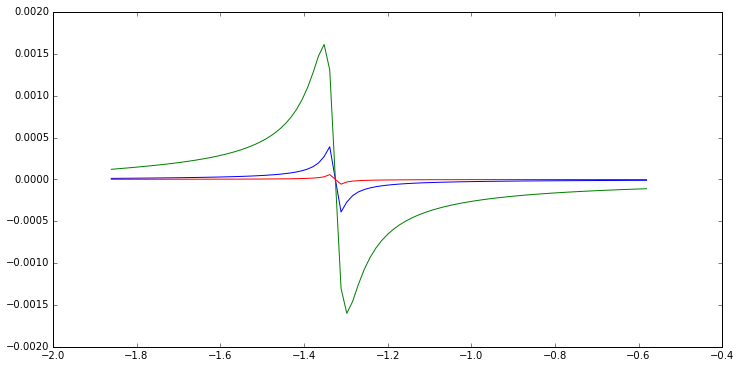

In [114]:
plot(xs[:,0],dO(vs,xs,xs[51],vs[51]))
plot(xs[:,0],dO(vs,xs,xs[51],vs[51],GM=10**-3./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.250/R0))
plot(xs[:,0],dO(vs,xs,xs[51],vs[51],GM=10**-5./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.04/R0))

Add a random set of kicks of a certain mass

In [93]:
def randomdO(nimpacts,xs,vs,GM=10**-4./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.100/R0):
    out= numpy.zeros(len(xs))
    for ii in range(nimpacts):
        randindx= int(numpy.floor(numpy.random.uniform(size=1)*len(xs)))
        out+= dO(vs,xs,xs[randindx],vs[randindx],GM=GM,rs=rs)
    return out

This is what it does to the stream. We assume that the subhalo mass spectrum is dN/dM ~ M$^{-2}$ (i.e., there are 10x more subhalos of 10x smaller mass). Note that the overall effect on the stream is very similar for all mass ranges:

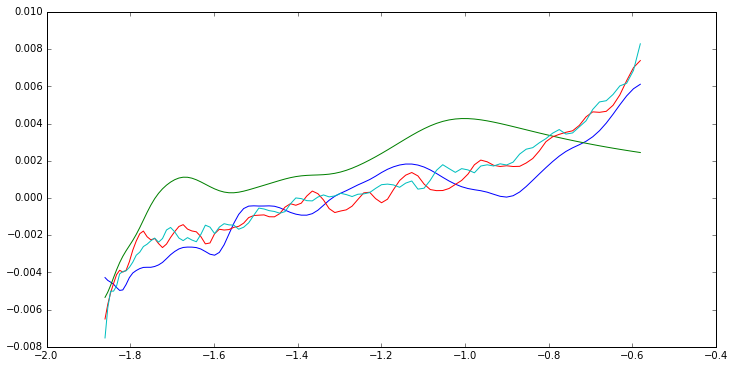

In [113]:
plot(xs[:,0],randomdO(100,vs,xs))
plot(xs[:,0],randomdO(10,vs,xs,GM=10**-3./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.250/R0))
plot(xs[:,0],randomdO(1000,vs,xs,GM=10**-5./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.04/R0))
plot(xs[:,0],randomdO(10000,vs,xs,GM=10**-6./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.016/R0))

What follows are some power spectra for random realizations of hits (first plot) and the median over many different realizations. There is a rather wide variation for different realizations, but in the median, the small halos induce more small-scale structure in the frequencies:

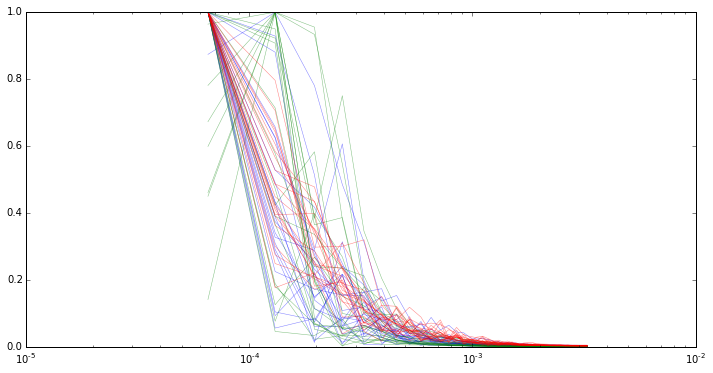

In [109]:
figsize(12,6)
for ii in range(21):
    px, py=signal.periodogram(randomdO(100,vs,xs),fs=(xs[1,0]-xs[0,0])) 
    semilogx(px,py/numpy.amax(py),color='b',lw=0.5,alpha=0.5)
for ii in range(21):
    px, py= signal.periodogram(randomdO(10,vs,xs,GM=10**-3./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.250/R0),fs=(xs[1,0]-xs[0,0]))
    semilogx(px,py/numpy.amax(py),color='g',lw=0.5,alpha=0.5)
for ii in range(21):
    px, py= signal.periodogram(randomdO(1000,vs,xs,GM=10**-5./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.04/R0),fs=(xs[1,0]-xs[0,0]))
    semilogx(px,py/numpy.amax(py),color='r',lw=0.5,alpha=0.5)

0.044367418618
0.0484188026484


KeyboardInterrupt: 

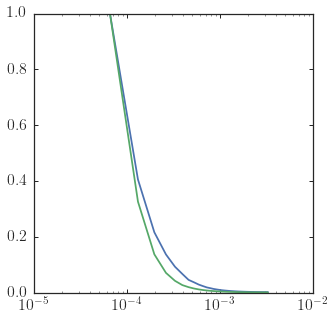

In [270]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
ppy= numpy.zeros((len(px),1001))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.periodogram(randomdO(100,vs,xs),fs=(xs[1,0]-xs[0,0]))[1]
semilogx(px,numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1)))
print numpy.amax(numpy.median(ppy,axis=1))
ppy= numpy.zeros((len(px),1001))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.periodogram(randomdO(10,vs,xs,GM=10**-3./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.250/R0),fs=(xs[1,0]-xs[0,0]))[1]
semilogx(px,numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1)))
print numpy.amax(numpy.median(ppy,axis=1))
ppy= numpy.zeros((len(px),1001))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.periodogram(randomdO(1000,vs,xs,GM=10**-5./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.04/R0),fs=(xs[1,0]-xs[0,0]))[1]
semilogx(px,numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1)))
print numpy.amax(numpy.median(ppy,axis=1))
ppy= numpy.zeros((len(px),1001))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.periodogram(randomdO(10000,vs,xs,GM=10**-6./bovy_conversion.mass_in_1010msol(V0,R0),rs=0.016/R0),fs=(xs[1,0]-xs[0,0]))[1]
semilogx(px,numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1)))
print numpy.amax(numpy.median(ppy,axis=1))

## More realistic simulations

To perform more realistic simulations we will do the following:
    
    * We'll assume that the stream is frozen at the time of impact (i.e., no new stars are added after the impacts, which would dilute the signal)
    * We still use a single mass for each mass-bin (and a single scale radius)
    * We include hits with impact parameters between 0 and 2 x the scale radius (Carlberg 2012)
    * We draw subhalo velocities from a Gaussian with an isotropic dispersion of 150 km/s
    * All impacts happen at the same time
    * We only look at the stream at the time of impact
    
We will load the galpy model for the gap in Sanders, Bovy, & Erkal (2015) as the stream model, hitting the stream at 10 Gyr

In [122]:
try:
    reload(galpy.df)
except NameError:
    import galpy.df
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_plot

In [126]:
sigv= 0.365*(10./2.)**(1./3.)
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1])[0],prog_init.y(times[-1])[0],prog_init.z(times[-1]),
              prog_init.vx(times[-1])[0],prog_init.vy(times[-1])[0],prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5]])
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)
sdfl_per_1e8_peri= galpy.df.streamgapdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                        leading=False,nTrackChunks=26,nTrackIterations=1,
                                        sigMeanOffset=4.5,
                                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        Vnorm=V0,Rnorm=R0,
                                        impactb=0.,
                                        subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0, # from Denis' email
                                        timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        impact_angle=-2.34,
                                        GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                        rs=0.625/R0) 

In [223]:
def rs(M):
    """Give scale radius for a given mass"""
    return (M/10**7.)**0.4*0.25/R0
def N(M):
    return 10.*(10.**7./M)

In [225]:
thetapars= sdfl_per_1e8_peri._kick_interpolatedThetasTrack
def randomdvs(GM,sdf,rate=None):
    """Construct a random set of impacts; inputs:
    
    M: mass of subhalo (/Msolar)
    sdf: a streamgapdf object that we can use to compute kicks
    rate: expected number of impacts
    """
    if rate is None: rate= N(GM)
    # First we sample angles at which the impacts occur, starting at the progenitor
    angles= numpy.cumsum(numpy.random.exponential(scale=1./rate,size=int(numpy.ceil(rate))))
    angles= angles[angles < 1.]*sdf._deltaAngleTrackImpact*sdf._gap_sigMeanSign
    nimpacts= len(angles)
    # Now we sample for each impact impact parameters and halo velocities and compute dv
    dvs= numpy.zeros((nimpacts,len(thetapars),3)) 
    dvdotvs= numpy.zeros((nimpacts,len(thetapars)))
    for ii, angle in enumerate(angles):
        b= numpy.random.uniform()*4.*rs(GM)-2.*rs(GM)
        v= numpy.random.normal(scale=150./V0,size=3)
        # Get the stream at the closest-approach point
        kick_ObsTrackXY_closest= numpy.array([\
                sdf._kick_interpTrackX(angle),
                sdf._kick_interpTrackY(angle),
                sdf._kick_interpTrackZ(angle),
                sdf._kick_interpTrackvX(angle),
                sdf._kick_interpTrackvY(angle),
                sdf._kick_interpTrackvZ(angle)])
        dvs[ii]= impulse_deltav_plummer_curvedstream(
            sdf._kick_interpolatedObsTrackXY[:,3:],
            sdf._kick_interpolatedObsTrackXY[:,:3],
            b,v,
            kick_ObsTrackXY_closest[:3],
            kick_ObsTrackXY_closest[3:],
            GM/bovy_conversion.mass_in_msol(V0,R0),rs(GM))
        dvdotvs[ii]= numpy.dot(dvs[ii],kick_ObsTrackXY_closest[3:])
    return (dvs,dvdotvs)

Let's look at delta vs

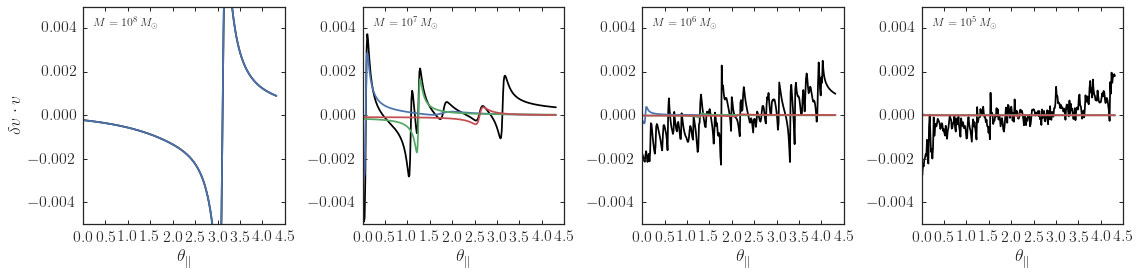

In [274]:
figsize(16,4)
subplot(1,4,1)
dvs, dvdotvs= randomdvs(10**8,sdfl_per_1e8_peri)
plot(thetapars,dvdotvs[0,:])
plot(thetapars,numpy.sum(dvdotvs,axis=0),zorder=0,color='k')
xlabel(r'$\theta_\parallel$')
ylabel(r'$\delta v\cdot v$')
ylim(-0.005,0.005)
bovy_plot.bovy_text(r'$M = 10^8\,M_\odot$',top_left=True)
subplot(1,4,2)
dvs, dvdotvs= randomdvs(10**7,sdfl_per_1e8_peri)
plot(thetapars,dvdotvs[0,:])
plot(thetapars,dvdotvs[3,:])
plot(thetapars,dvdotvs[5,:])
plot(thetapars,numpy.sum(dvdotvs,axis=0),zorder=0,color='k')
xlabel(r'$\theta_\parallel$')
ylim(-0.005,0.005)
bovy_plot.bovy_text(r'$M = 10^7\,M_\odot$',top_left=True)
subplot(1,4,3)
dvs, dvdotvs= randomdvs(10**6,sdfl_per_1e8_peri)
plot(thetapars,dvdotvs[0,:])
plot(thetapars,dvdotvs[30,:])
plot(thetapars,dvdotvs[50,:])
plot(thetapars,numpy.sum(dvdotvs,axis=0),zorder=0,color='k')
xlabel(r'$\theta_\parallel$')
ylim(-0.005,0.005)
bovy_plot.bovy_text(r'$M = 10^6\,M_\odot$',top_left=True)
subplot(1,4,4)
dvs, dvdotvs= randomdvs(10**5,sdfl_per_1e8_peri)
plot(thetapars,dvdotvs[0,:])
plot(thetapars,dvdotvs[300,:])
plot(thetapars,dvdotvs[500,:])
plot(thetapars,numpy.sum(dvdotvs,axis=0),zorder=0,color='k')
xlabel(r'$\theta_\parallel$')
ylim(-0.005,0.005)
bovy_plot.bovy_text(r'$M = 10^5\,M_\odot$',top_left=True)
tight_layout()

Now we look at the (median) power spectra of these deviations:

6.1423521373e-08
7.35485347952e-08
1.68779800223e-07
2.90803783561e-07


(0.01, 1.0)

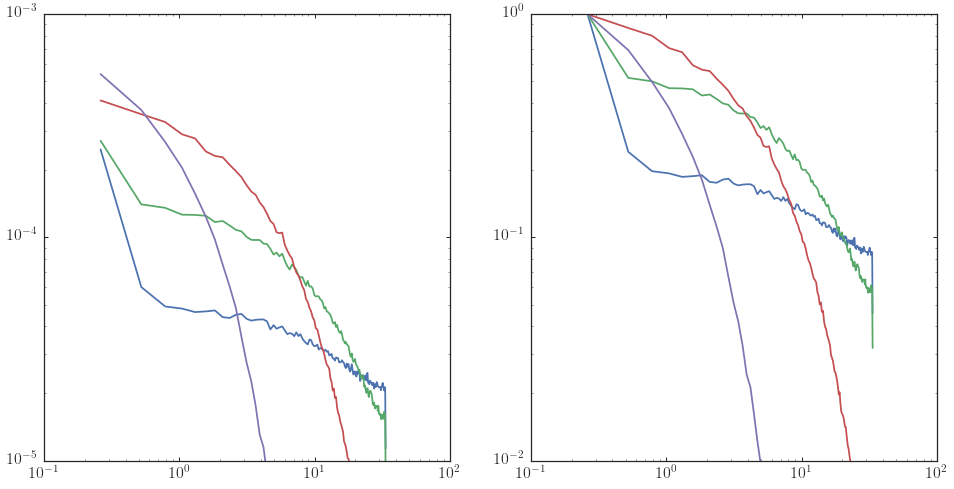

In [338]:
figsize(16,8)
ntrials= 1001
# Just to get the sampling frequencies
px= signal.welch(numpy.sum(randomdvs(10**7.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[0]
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.welch(numpy.sum(randomdvs(10**5.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
subplot(1,2,1)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
subplot(1,2,2)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1))))
print numpy.amax(numpy.median(ppy,axis=1))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.welch(numpy.sum(randomdvs(10**6.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
subplot(1,2,1)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
subplot(1,2,2)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1))))
print numpy.amax(numpy.median(ppy,axis=1))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.welch(numpy.sum(randomdvs(10**7.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
subplot(1,2,1)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
subplot(1,2,2)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1))))
print numpy.amax(numpy.median(ppy,axis=1))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.welch(numpy.sum(randomdvs(10**7.85,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
subplot(1,2,1)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
ylim(10**-5.,10.**-3.)
subplot(1,2,2)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1))))
print numpy.amax(numpy.median(ppy,axis=1))
ylim(10**-2.,1.)

More realistic subhalo numbers (assume N~sqrt(M) to take into account shrinking sphere of influence)

7.6214984784e-10
1.09772733679e-08
1.88375897573e-07
1.75937713928e-06


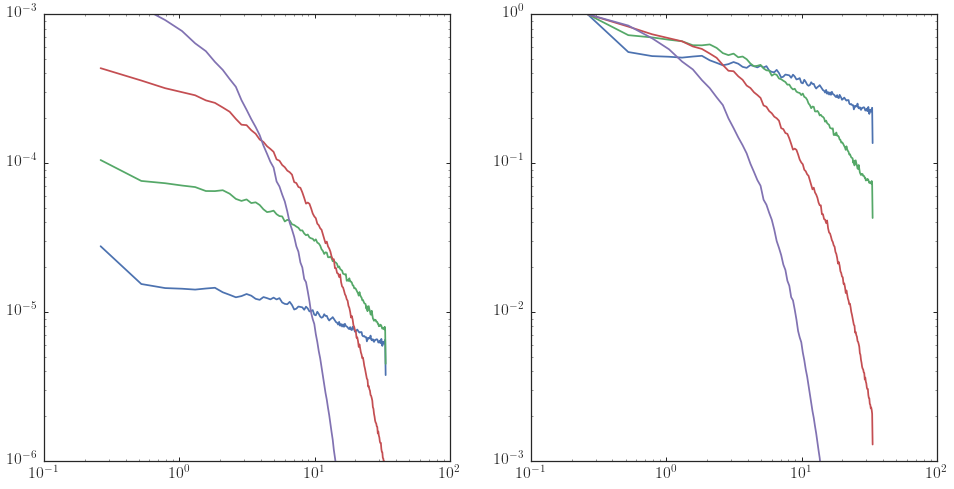

In [335]:
def N(M):
    return 10.*(10.**7./M)**0.5
figsize(16,8)
ntrials= 1001
# Just to get the sampling frequencies
px= signal.welch(numpy.sum(randomdvs(10**7.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[0]
ppy= numpy.zeros((len(px),ntrials))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.welch(numpy.sum(randomdvs(10**5.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
subplot(1,2,1)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
subplot(1,2,2)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1))))
print numpy.amax(numpy.median(ppy,axis=1))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.welch(numpy.sum(randomdvs(10**6.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
subplot(1,2,1)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
subplot(1,2,2)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1))))
print numpy.amax(numpy.median(ppy,axis=1))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.welch(numpy.sum(randomdvs(10**7.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
subplot(1,2,1)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
subplot(1,2,2)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1))))
print numpy.amax(numpy.median(ppy,axis=1))
for ii in range(ppy.shape[1]):
    ppy[:,ii]= signal.welch(numpy.sum(randomdvs(10**7.85,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
subplot(1,2,1)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)))
ylim(10**-6.,10.**-3.)
subplot(1,2,2)
loglog(px,numpy.sqrt(numpy.median(ppy,axis=1)/numpy.amax(numpy.median(ppy,axis=1))))
print numpy.amax(numpy.median(ppy,axis=1))
ylim(10**-3.,1.)
# Go back to original definition
def N(M):
    return 10.*(10.**7./M)

Back to N~M, but showing individual streams

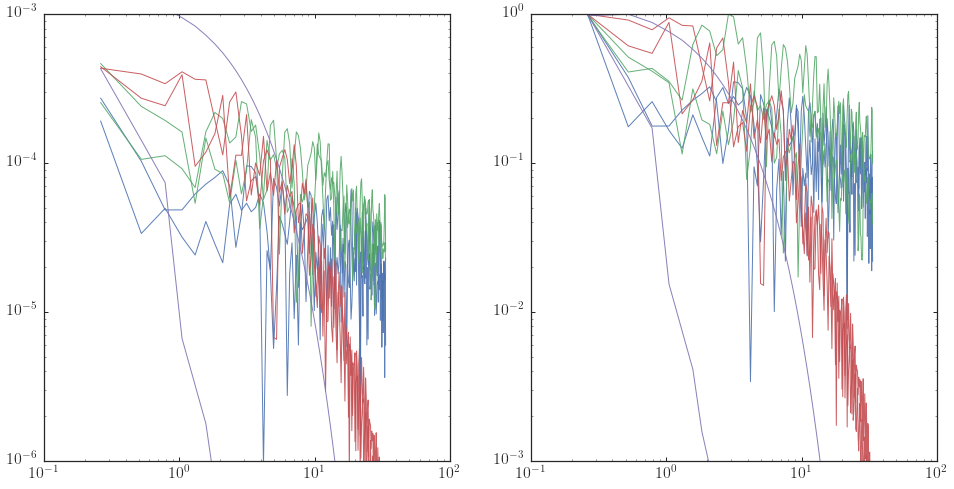

In [334]:
figsize(16,8)
ntrials= 2
plotkwargs= {'alpha':.9,'lw':1.}
# Just to get the sampling frequencies
px= signal.welch(numpy.sum(randomdvs(10**7.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[0]
for ii in range(ntrials):
    ppy= signal.welch(numpy.sum(randomdvs(10**5.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
    subplot(1,2,1)
    loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[0],**plotkwargs)
    subplot(1,2,2)
    loglog(px,numpy.sqrt(ppy/numpy.amax(ppy)),color=sns.color_palette()[0],**plotkwargs)
for ii in range(ntrials):
    ppy= signal.welch(numpy.sum(randomdvs(10**6.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
    subplot(1,2,1)
    loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
    subplot(1,2,2)
    loglog(px,numpy.sqrt(ppy/numpy.amax(ppy)),color=sns.color_palette()[1],**plotkwargs)
for ii in range(ntrials):
    ppy= signal.welch(numpy.sum(randomdvs(10**7.,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
    subplot(1,2,1)
    loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
    subplot(1,2,2)
    loglog(px,numpy.sqrt(ppy/numpy.amax(ppy)),color=sns.color_palette()[2],**plotkwargs)
for ii in range(ntrials):
    ppy= signal.welch(numpy.sum(randomdvs(10**7.85,sdfl_per_1e8_peri)[1],axis=0),
                                  fs=1./(thetapars[1]-thetapars[0]),scaling='spectrum')[1]
    subplot(1,2,1)
    loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[3],**plotkwargs)
    ylim(10**-6.,10.**-3.)
    subplot(1,2,2)
    loglog(px,numpy.sqrt(ppy/numpy.amax(ppy)),color=sns.color_palette()[3],**plotkwargs)
    ylim(10**-3.,1.)